In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
! cp drive/MyDrive/DMG/Assignment2/df_modcloth.csv .

In [3]:
import pandas as pd
import numpy as np
dataframe_cloth = pd.read_csv('df_modcloth.csv')
dataframe_cloth = dataframe_cloth.drop(["timestamp","split","user_attr"],axis = 1)
dataframe_cloth['fit'] = dataframe_cloth['fit'].apply(lambda x: -2 if x == 'Very small' else
                                                       (-1 if x == 'Slightly small' else
                                                        (1 if x == 'Slightly large' else
                                                         (2 if x == 'Very large' else 0))))
dataframe_cloth["model_attr"] = dataframe_cloth["model_attr"].apply(lambda x: 1 if x=='Small'else 2)
global_mean = dataframe_cloth["size"].mean()
dataframe_cloth["size"] = dataframe_cloth["size"].replace(np.nan, global_mean)
global_mean = dataframe_cloth["rating"].mean()

In [4]:
items_unique = dataframe_cloth["item_id"].unique()
users_unique = dataframe_cloth["user_id"].unique()
items = dataframe_cloth["item_id"]
users = dataframe_cloth["user_id"]

In [5]:
feature_vector = []
dataframe_cloth_grouped = dataframe_cloth.groupby('item_id')
for item in items_unique:
  feature_vector.append([dataframe_cloth_grouped['size'].get_group(item).mean(),dataframe_cloth_grouped['fit'].get_group(item).mean(),dataframe_cloth_grouped['model_attr'].get_group(item).mean(),dataframe_cloth_grouped['year'].get_group(item).iloc[0],dataframe_cloth_grouped['category'].get_group(item).iloc[0],dataframe_cloth_grouped['brand'].get_group(item).iloc[0]])

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
feature_vector_df = pd.DataFrame(feature_vector, columns=['size', 'fit', 'model_attr',"year",'category','brand'])
feature_vector_df = pd.get_dummies(feature_vector_df, columns=['category', 'brand'])
# Combine numerical attributes with the encoded categorical attributes
feature_vector_df['feature_vector'] = feature_vector_df.apply(lambda row: [row['size'], row['fit'],row['model_attr'], row['year']] + row[4:].tolist(), axis=1)
feature_vector_list = feature_vector_df["feature_vector"]
feature_vector_arr = []

for i in range(len(feature_vector_list)):
  feature_vector_arr.append(feature_vector_list[i])
feature_vector_arr = np.array(feature_vector_arr)

mean_ = np.mean(feature_vector_arr, axis=0)
std_ = np.std(feature_vector_arr, axis=0)
feature_vector_normalized = (feature_vector_arr - mean_)/std_


item_similarity_matrix = cosine_similarity(feature_vector_normalized)
cosine_similarity_df = pd.DataFrame(item_similarity_matrix, columns=items_unique, index=items_unique)

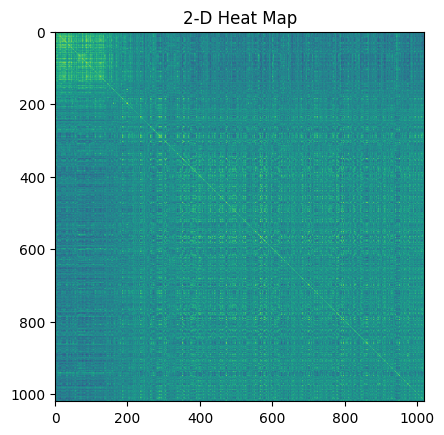

In [9]:
# Heat Map for the item_similarity matrix
import matplotlib.pyplot as plt
plt.imshow(item_similarity_matrix)

plt.title( "2-D Heat Map" )
plt.show()

In [ ]:
user_item_df = pd.DataFrame(0, index=users_unique, columns=items_unique)
for i in range(len(dataframe_cloth)):
  row = dataframe_cloth.iloc[i]
  user_item_df.loc[row["user_id"]][row["item_id"]] = row["rating"]

In [ ]:
from sklearn.model_selection import train_test_split
dataframe_cloth['Count'] = dataframe_cloth.groupby('item_id')['item_id'].transform('count')
dataframe_cloth_more_than_one_entry = dataframe_cloth[dataframe_cloth['Count'] > 1]
data_x = np.array((dataframe_cloth_more_than_one_entry.loc[:,["user_id","item_id"]]))
data_y_ = np.array(dataframe_cloth_more_than_one_entry.loc[:,dataframe_cloth_more_than_one_entry.columns == "rating"])
data_y = []
for i in range(len(data_y_)):
  data_y.append(data_y_[i][0])
data_y = np.array(data_y)
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.15,stratify=data_x[:,1],random_state=42)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_iteration_wise = []
all_predictions = []
count = 0
k_fold_cross_validation = StratifiedKFold(n_splits=5)
for train_index, validation_index in k_fold_cross_validation.split(train_x,train_y):
    train_dict = {}
    predictions = []
    train_item_dict = {}
    train_fold_x, validation_fold_x = train_x[train_index], train_x[validation_index]
    train_fold_y, validation_fold_y = train_y[train_index], train_y[validation_index]
    for i in range(len(train_fold_x)):
        if train_fold_x[i][0] not in train_dict:
          train_dict[train_fold_x[i][0]] = [i]
        else:
          train_dict[train_fold_x[i][0]].append(i)
    for i in range(len(train_fold_x)):
        if train_fold_x[i][1] not in train_item_dict:
          train_item_dict[train_fold_x[i][1]] = [train_fold_y[i]]
        else:
          train_item_dict[train_fold_x[i][1]].append(train_fold_y[i])
    for i in range(len(validation_fold_x)):
      if(validation_fold_x[i][0] in train_dict):
        mysum = 0
        prediction = 0
        flag = 0
        for train_index in train_dict[validation_fold_x[i][0]]:
          cosine_sim = cosine_similarity_df.loc[validation_fold_x[i][1]][train_fold_x[train_index][1]]
          if(cosine_sim > 0):
            prediction += cosine_similarity_df.loc[validation_fold_x[i][1]][train_fold_x[train_index][1]] * train_fold_y[train_index]
            mysum += cosine_similarity_df.loc[validation_fold_x[i][1]][train_fold_x[train_index][1]]
            flag = 1
        if(flag == 1):
          predictions.append(prediction/mysum)
        else:
          if validation_fold_x[i][1] in train_item_dict:
            mylist = train_item_dict[validation_fold_x[i][1]]
            predictions.append(sum(mylist) / len(mylist))
          else:
            predictions.append(global_mean)
            count += 1
      else:
        if validation_fold_x[i][1] in train_item_dict:
            mylist = train_item_dict[validation_fold_x[i][1]]
            predictions.append(sum(mylist) / len(mylist))
        else:
            predictions.append(global_mean)
            count += 1
    mse = mean_squared_error(validation_fold_y, predictions)
    rmse = sqrt(mse)
    all_predictions.append(predictions)
    rmse_iteration_wise.append(rmse)


In [ ]:
print("mean rmse for 5 folds is {}".format(sum(rmse_iteration_wise)/len(rmse_iteration_wise)))
print("Iteration-wise rmse is {}".format(rmse_iteration_wise))

mean rmse for 5 folds is 1.1640811128566666
Iteration-wise rmse is [1.1640743468815817, 1.1650372750747184, 1.1671211359837417, 1.15261748827398, 1.1715553180693117]


In [ ]:
#test
train_dict = {}
predictions = []
train_item_dict = {}
for i in range(len(train_x)):
    if train_x[i][0] not in train_dict:
      train_dict[train_x[i][0]] = [i]
    else:
      train_dict[train_x[i][0]].append(i)
for i in range(len(train_x)):
    if train_x[i][1] not in train_item_dict:
      train_item_dict[train_x[i][1]] = [train_y[i]]
    else:
      train_item_dict[train_x[i][1]].append(train_y[i])
for i in range(len(test_x)):
  if(test_x[i][0] in train_dict):
    mysum = 0
    prediction = 0
    flag = 0
    for train_index in train_dict[test_x[i][0]]:
      cosine_sim = cosine_similarity_df.loc[test_x[i][1]][train_x[train_index][1]]
      if(cosine_sim > 0):
        prediction += cosine_similarity_df.loc[test_x[i][1]][train_x[train_index][1]] * train_y[train_index]
        mysum += cosine_similarity_df.loc[test_x[i][1]][train_x[train_index][1]]
        flag = 1
    if(flag == 1):
      predictions.append(prediction/mysum)
    else:
      if test_x[i][1] in train_item_dict:
        mylist = train_item_dict[test_x[i][1]]
        predictions.append(sum(mylist) / len(mylist))
      else:
        predictions.append(global_mean)
        count += 1
  else:
    if test_x[i][1] in train_item_dict:
        mylist = train_item_dict[test_x[i][1]]
        predictions.append(sum(mylist) / len(mylist))
    else:
        predictions.append(global_mean)
        count += 1
mse = mean_squared_error(test_y, predictions)
rmse = sqrt(mse)
print(rmse)

1.1619350847083567


In [ ]:
print("Test RMSE is {}".format(rmse))

Test RMSE is 1.1619350847083567
